In [4]:
import matplotlib.pyplot as plt 
import sys
# sys.path.append("../")
from LSTM_Net import LSTM_Net 
import torch 
import torch.nn as nn 
import numpy as np 
import math 
from scipy.signal import ricker
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import m8r as sf
from skimage.transform import resize
import matplotlib as mlp
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random


opath = './Fig/'

wav = ricker(50,5)
wav2= ricker(50,3)
wav3= ricker(100,6)
wav4= ricker(200,6)
x = np.concatenate((wav,0.5*wav2,-0.3*wav3,0.8*wav,-0.5*wav4),axis=0)

y = np.concatenate((x,0.3*wav4,0.6*wav3),axis=0)
x = np.concatenate((x,0.3*0.2*wav4,0.6*wav3),axis=0)

x = np.pad(x, (50,100), 'constant', constant_values=(0, 0))
y = np.pad(y, (60,90), 'constant', constant_values=(0, 0)) *0.75

feature_length= 21

# sigma= 1e-2
energy = (x**2).mean()
snr = 100/10
x = x + np.random.normal(0.,  np.sqrt(energy/snr ), x.shape)
y = y + np.random.normal(0., np.sqrt(energy/snr ), y.shape)



### 
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

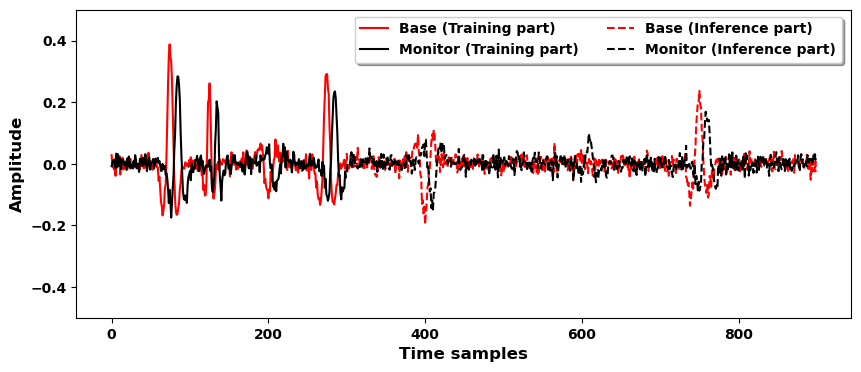

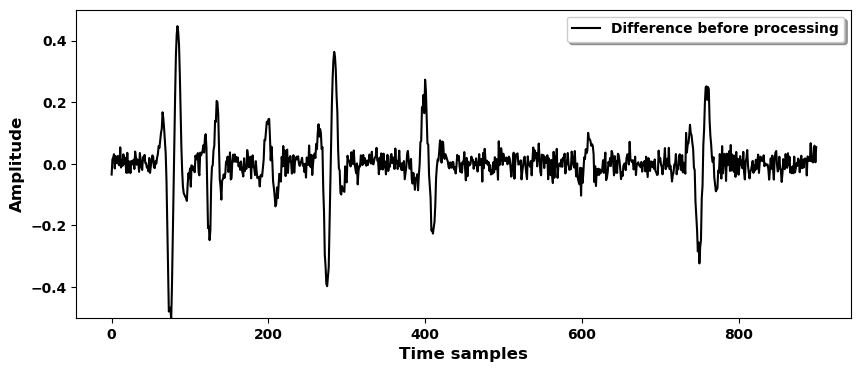

In [5]:
x1 = x.copy()
y1 = y.copy()
x2 = x.copy()
y2 = y.copy()


x1[300:,] = np.nan
y1[300:,] = np.nan
x2[:300,] = np.nan
y2[:300,] = np.nan


font = {
    'weight' : 'bold',
    'size'   : 10}
mlp.rc('font', **font)







plt.figure(figsize=(10,4))
plt.plot(x1,label='Base (Training part)',color='red')
plt.plot(y1,label='Monitor (Training part)',color='black')
plt.plot(x2,'--',label='Base (Inference part)',color='red')
plt.plot(y2,'--',label='Monitor (Inference part)',color='black')
plt.legend(fontsize=10,bbox_to_anchor=(0.35,1),ncol=2,shadow=True)
plt.xlabel('Time samples',fontsize=12,fontweight='heavy')
plt.ylabel('Amplitude',fontsize=12,fontweight='heavy')
plt.ylim(-.5,.5)
plt.savefig(opath+'Noise_trace_matching_1')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(y-x,label='Noise_Difference before processing',color='black')
plt.xlabel('Time samples',fontsize=12,fontweight='heavy')
plt.ylabel('Amplitude',fontsize=12,fontweight='heavy')
plt.legend(fontsize=10,shadow=True)
plt.ylim(-.5,.5)
plt.savefig(opath+'trace_difference_before')
plt.show()

torch.Size([280, 1, 21])
torch.Size([280, 1, 1])
epoch:   1  Loss: 2.00133e-01
epoch:   2  Loss: 1.01150e-01
epoch:   3  Loss: 1.17636e-01
epoch:   4  Loss: 7.52119e-02
epoch:   5  Loss: 7.02821e-02
epoch:   6  Loss: 7.26786e-02
epoch:   7  Loss: 6.79145e-02
epoch:   8  Loss: 5.70544e-02
epoch:   9  Loss: 4.59896e-02
epoch:  10  Loss: 4.11416e-02
epoch:  11  Loss: 4.04866e-02
epoch:  12  Loss: 3.29752e-02
epoch:  13  Loss: 2.25436e-02
epoch:  14  Loss: 2.23300e-02
epoch:  15  Loss: 2.62236e-02
epoch:  16  Loss: 2.06955e-02
epoch:  17  Loss: 1.75315e-02
epoch:  18  Loss: 2.02412e-02
epoch:  19  Loss: 1.94631e-02
epoch:  20  Loss: 1.56732e-02
epoch:  21  Loss: 1.42105e-02
epoch:  22  Loss: 1.50614e-02
epoch:  23  Loss: 1.54381e-02
epoch:  24  Loss: 1.41495e-02
epoch:  25  Loss: 1.22155e-02
epoch:  26  Loss: 1.13691e-02
epoch:  27  Loss: 1.21048e-02
epoch:  28  Loss: 1.27423e-02
epoch:  29  Loss: 1.19103e-02
epoch:  30  Loss: 1.07597e-02
epoch:  31  Loss: 1.05803e-02
epoch:  32  Loss: 1.0

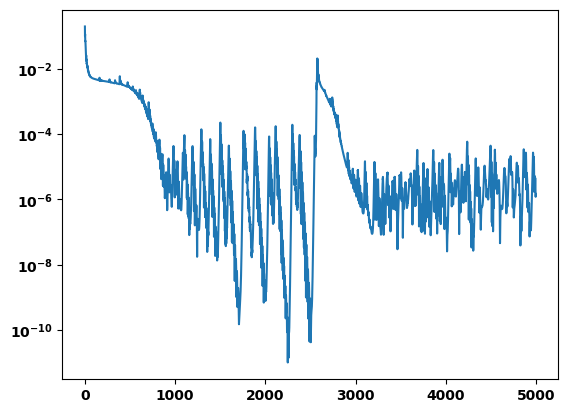

In [7]:
x = x.reshape((-1,1))[:300]
y = y.reshape((-1,1))[:300]


# x = torch.from_numpy(x).float()
# y = torch.from_numpy(y).float()

scale ='minmax'

if scale == 'minmax':
        scalerx= MinMaxScaler((-1,1))
        scalerx.fit(x)
        x_sc = scalerx.transform(x)
        scalery= MinMaxScaler((-1,1))
        scalery.fit(y)
        y_sc = scalery.transform(y)

elif scale== 'standard': 
        scalerx= StandardScaler()
        scalerx.fit(x)
        x_sc = scalerx.transform(x)
        scalery= StandardScaler()
        scalery.fit(y)
        y_sc = scalery.transform(y)




x_sc = torch.from_numpy(x_sc).float()
y_sc = torch.from_numpy(y_sc).float()




def window (x,dimension=-1,size=21,step=1):
    ''' x has to be pytorch tensor'''
    return x.unfold(dimension,size,step)


x_sc =window(x_sc,dimension=0,size=feature_length,step=1)
y_sc =window(y_sc,dimension=0,size=feature_length,step=1)[:,:,feature_length//2]
y_sc = y_sc.view(y_sc.shape[0],y_sc.shape[1],-1)


print(x_sc.shape),print(y_sc.shape)



hsz=50    # hidden size
LR = 0.001 # learning rate
num_layer = 2
model = LSTM_Net(input_size=feature_length, hidden_layer_size=hsz, output_size=1,batch_sz=1,num_layer=num_layer) # model with (feature input,hidden_size,feature output, batch size)
model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LR)
scheduler = ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=10,threshold=1e-4,min_lr=1e-10)
 

##This is for whole 


inp = x_sc.view(1,x_sc.shape[0],-1).cuda()
target = y_sc.view(1,y_sc.shape[0],-1).cuda() 
loss = []
for epoch in range(5000): 
    model.h_init()

    y_pred = model(inp)
    running_loss = criterion(y_pred,target)
    running_loss.backward()
    # detach the hidden cell to allow subsequent backprop
    model.hidden_cell[0].detach_()
    model.hidden_cell[1].detach_()
    optimizer.step()
    optimizer.zero_grad()
    # scheduler.step(running_loss.item())

    print(f'epoch: {epoch+1:3}  Loss: {running_loss.item():.5e}'  ) 
    loss.append(running_loss.item())

plt.figure()
plt.semilogy(np.array(loss))
plt.show()
        
torch.save(model.state_dict(),f'./lstm_model_noise_{feature_length}samples.pth')